# Pest Classification with Transfer Learning

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
from sklearn.metrics import classification_report, confusion_matrix

# Loading the Data

In [2]:
dataset_path = '../datasets'

# Parameters
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
seed = 123

# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset='training',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
)

# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset='validation',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
)

Found 5494 files belonging to 12 classes.
Using 4396 files for training.
Found 5494 files belonging to 12 classes.
Using 1098 files for validation.


# Visualizing Samples from the Dataset

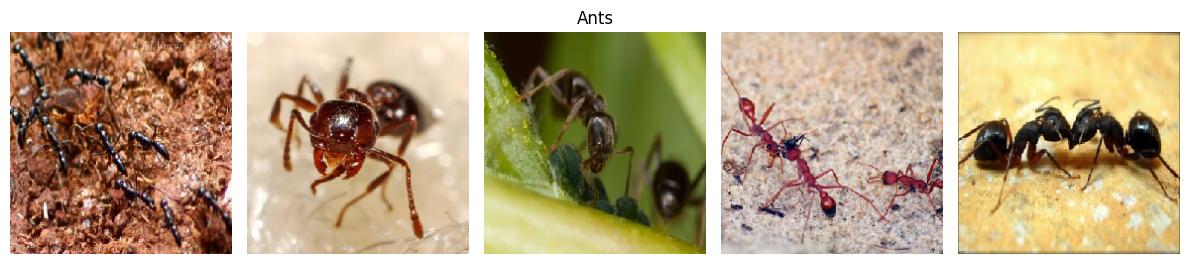

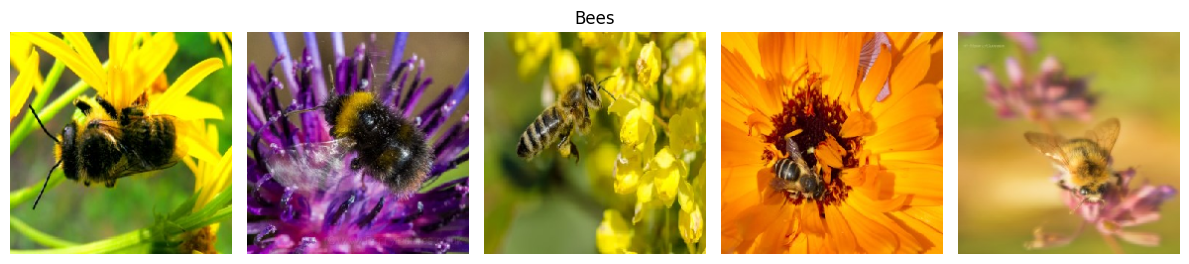

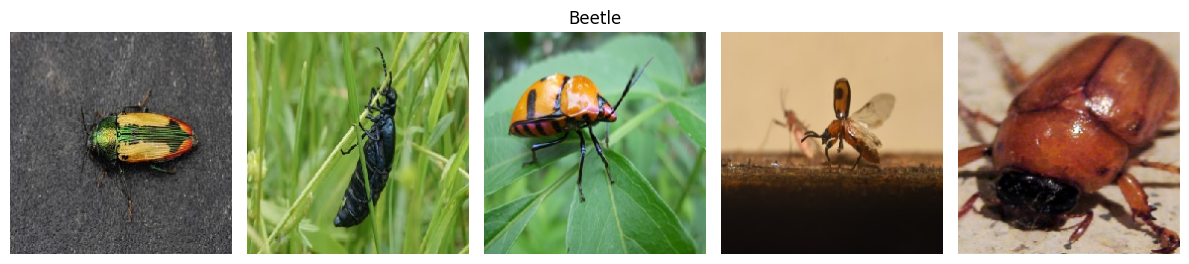

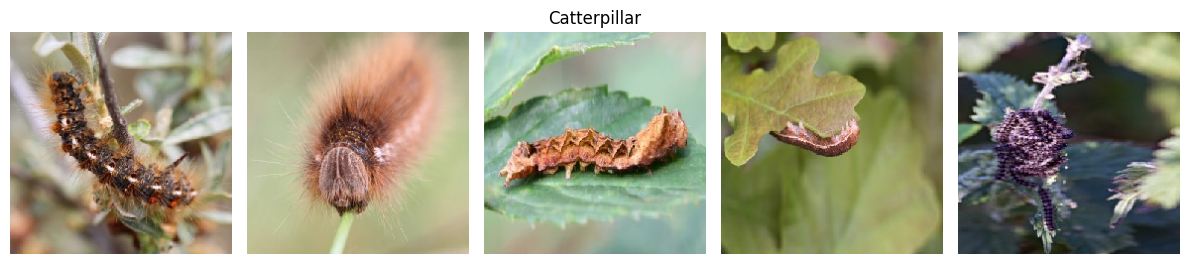

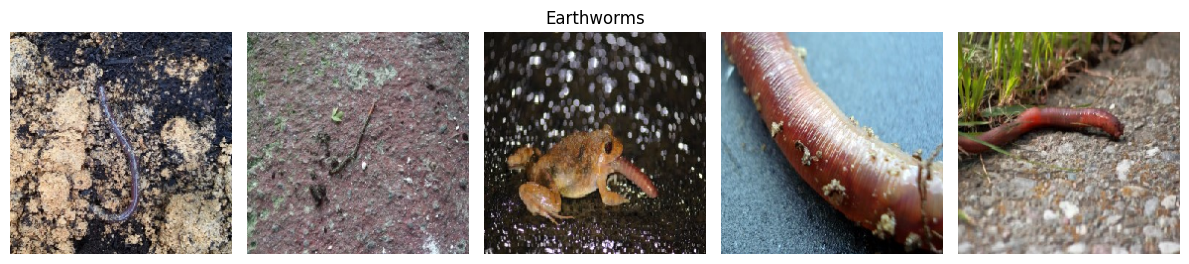

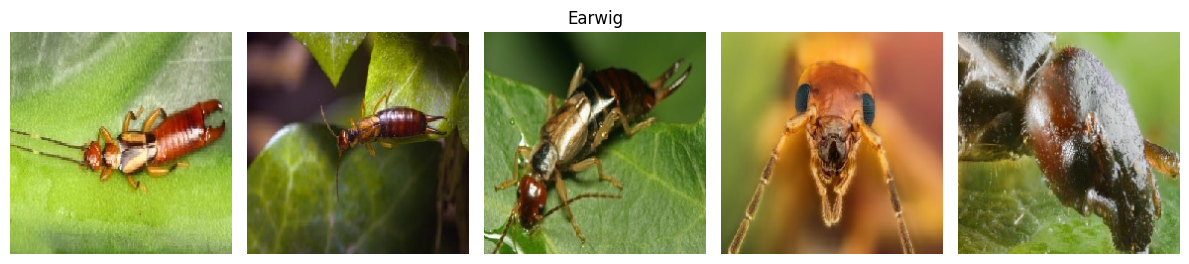

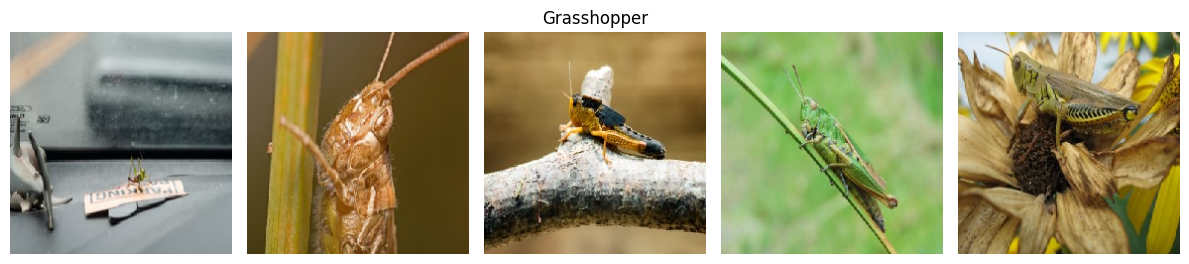

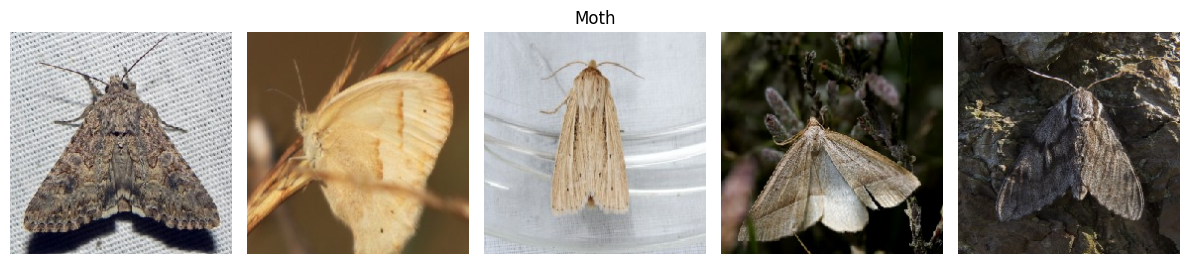

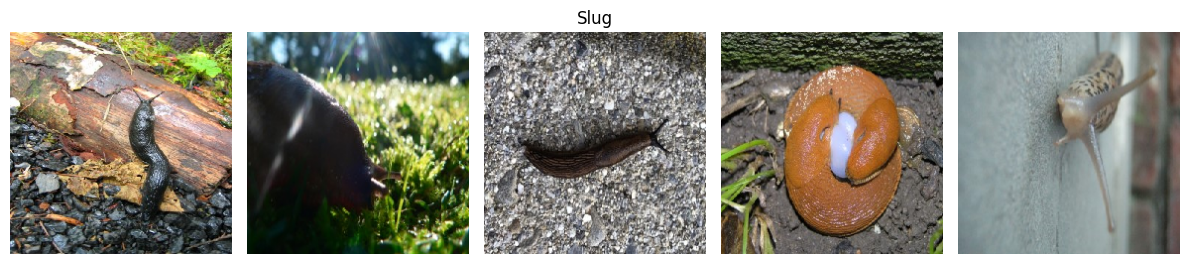

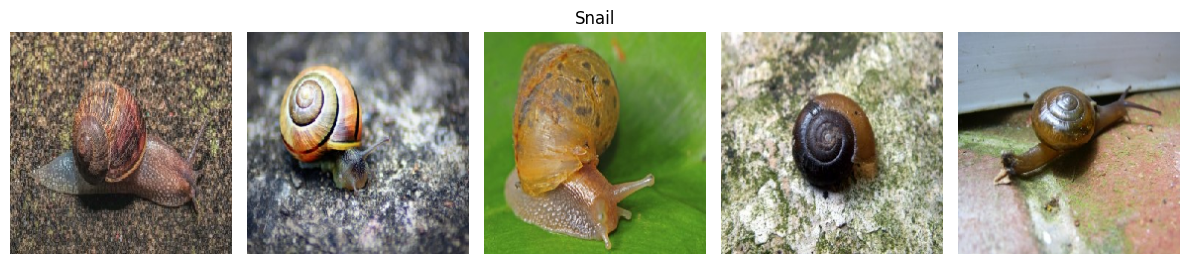

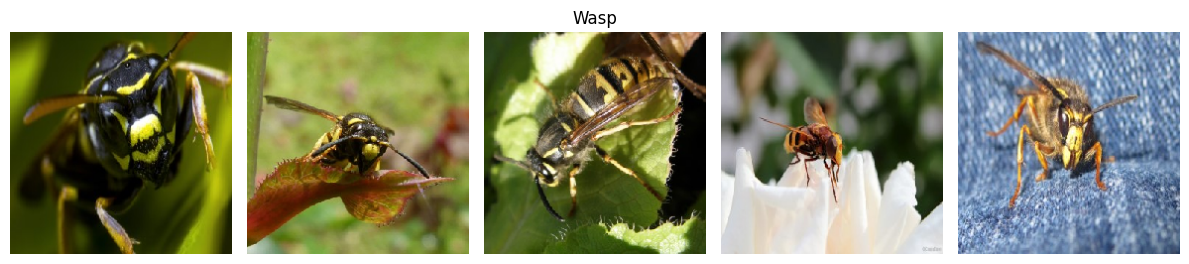

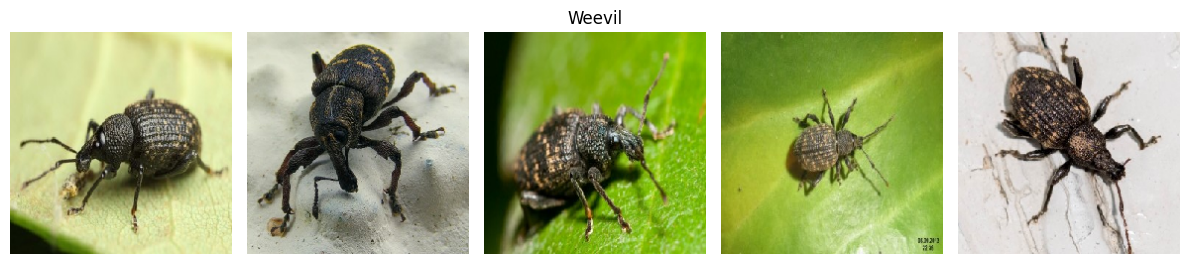

In [3]:
# Loop through each pest subfolder
for folder_name in [i for i in os.listdir(dataset_path)]:
    folder_path = os.path.join(dataset_path, folder_name)

    if os.path.isdir(folder_path):

        # List of images in current folder
        images = [img for img in os.listdir(folder_path)]
        rand_images = random.sample(images, 5)  # Select 5 random images from the folder
        fig, axes = plt.subplots(1, 5, figsize=(12, 6))
        for i, img_name in enumerate(rand_images):
            img_path = os.path.join(folder_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            ax = axes[i]
            if i == 2:
                ax.set_title(folder_name.title())  # Centralized title
            ax.imshow(img)
            ax.axis('off')  # Turn of ticks and labels
        plt.tight_layout()
        # plt.savefig(f'../images/{folder_name}_prev.png')
        plt.show()

# Model Creation

In [4]:
def createDenseBlock(prev_layer, n_units: int, dropout_rate: float = None):
    dense_layer = tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(prev_layer)
    if dropout_rate is None:
        return dense_layer
    dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate)(dense_layer)
    return dropout_layer

def create_vgg19(input_shape):
    input_layer = tf.keras.Input(shape=input_shape)
    # Preprocessing input data with vgg19 preprocessing function:
    tensor = tf.keras.applications.vgg19.preprocess_input(input_layer)
    # Model without top classification layers and imagenet weights
    model = tf.keras.applications.vgg19.VGG19(
        include_top=False,
        input_tensor=tensor,
    )
    # Not training the base model parameters
    model.trainable = False
    # Extract features from the preprocessed input data
    features = model(tensor)

    pooling = tf.keras.layers.GlobalAveragePooling2D()(features)
    # Dense blocks
    # Block 1
    dense1 = createDenseBlock(pooling, 512, 0.5)
    # Block 2
    dense2 = createDenseBlock(dense1, 128, 0.5)
    # Block 3
    dense3 = createDenseBlock(dense2, 32, 0.2)
    # Output layer
    output = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax')(dense3)
    # Create model with input and output layers
    model = tf.keras.Model(input_layer, output)
    return model

In [5]:
vgg19 = create_vgg19(input_shape=(img_height, img_width, 3))
vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664 

# Compiling the Model

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), # Stop after 5 epochs if val loss doesn't improve
    tf.keras.callbacks.ModelCheckpoint('../models/best_vgg19.h5', monitor='val_accuracy', save_best_only=True)  # Saves best model
]

vgg19.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

# Training the Model

In [7]:
vgg19_history = vgg19.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,
    callbacks=callbacks,
)

Epoch 1/45
138/138 [==============================] - 45s 264ms/step - loss: 5.5010 - accuracy: 0.2848 - val_loss: 3.8453 - val_accuracy: 0.5801
Epoch 2/45
138/138 [==============================] - 33s 238ms/step - loss: 3.7112 - accuracy: 0.4848 - val_loss: 2.9591 - val_accuracy: 0.6712
Epoch 3/45
138/138 [==============================] - 34s 244ms/step - loss: 2.9242 - accuracy: 0.5967 - val_loss: 2.3879 - val_accuracy: 0.7377
Epoch 4/45
138/138 [==============================] - 34s 248ms/step - loss: 2.4089 - accuracy: 0.6467 - val_loss: 1.9853 - val_accuracy: 0.7805
Epoch 5/45
138/138 [==============================] - 35s 250ms/step - loss: 2.0299 - accuracy: 0.6981 - val_loss: 1.7051 - val_accuracy: 0.7905
Epoch 6/45
138/138 [==============================] - 35s 250ms/step - loss: 1.7607 - accuracy: 0.7166 - val_loss: 1.4980 - val_accuracy: 0.8087
Epoch 7/45
138/138 [==============================] - 35s 251ms/step - loss: 1.5424 - accuracy: 0.7505 - val_loss: 1.3520 - val_ac

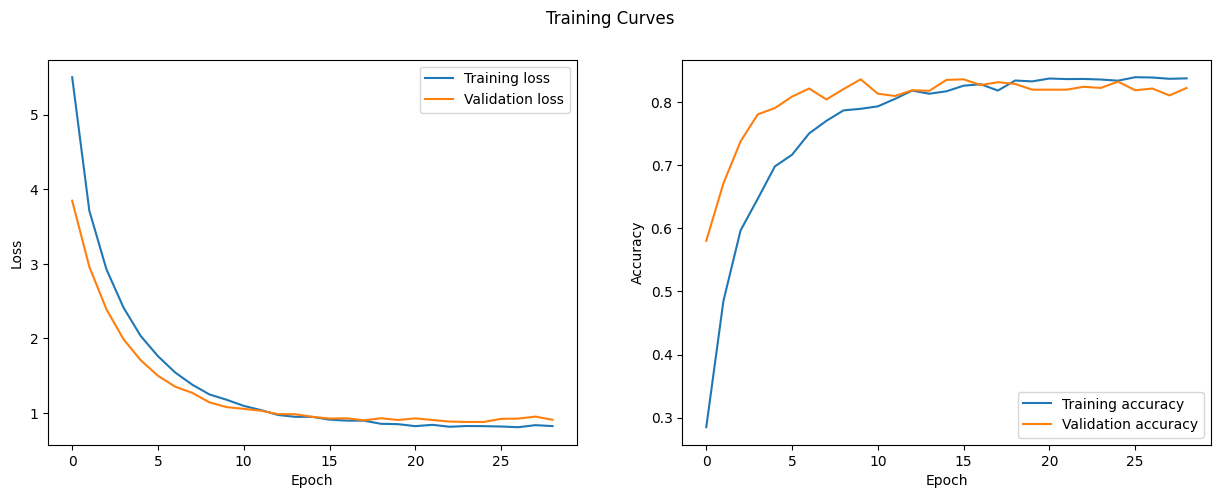

In [8]:
history = vgg19_history.history

plt.figure(figsize=(15, 5))  # Size of the complete figure
plt.subplot(1, 2, 1)  # Select first subplot
plt.plot(history['loss'], label='Training loss') 
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()  # Show the names for the color of lines in plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)  # Select second subplot
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.legend(loc='lower right')  # Show the names for the color of lines in plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.suptitle('Training Curves')  # Centered title for the figure
plt.show()

In [9]:
def show_performance_evaluation(model, datasets: list):
    for dataset in datasets:
        y_true = []
        y_pred = []
        for images, labels in dataset:
            y_true_batch = np.argmax(labels, axis=1)  # Convert one-hot encoded labels back to integer labels
            y_pred_batch = np.argmax(model.predict(images), axis=1)

            y_true.extend(y_true_batch)
            y_pred.extend(y_pred_batch)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # ----- Plotting a confusion matrix with seaborn ----- #
        plt.figure(figsize=(15, 8)) 
        class_names = dataset.class_names
        ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=class_names, yticklabels=class_names)  # Seaborn heatmap
        ax.set_title('Confusion Matrix') 
        plt.show()

        print('\n\nClassification Report:\n')
        print(classification_report(y_true, y_pred, labels=[i for i in range(0, 12)], target_names=class_names))

1/1 [==============================] - 0s 180ms/step


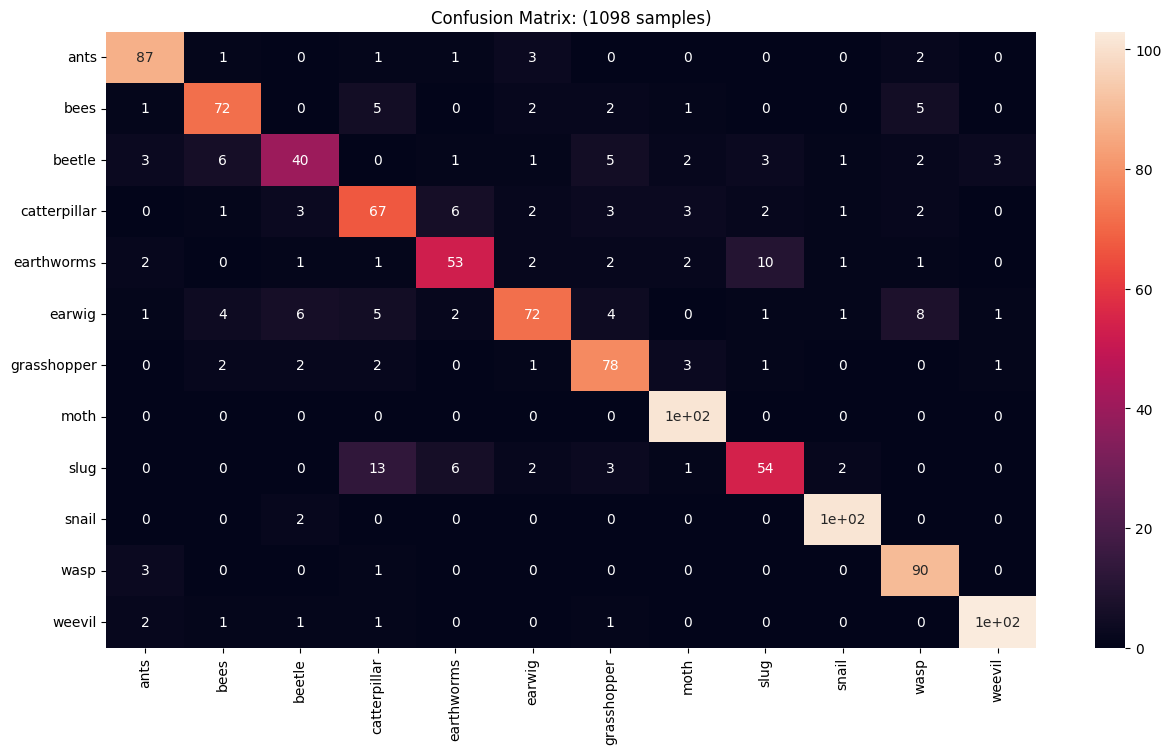



Classification Report:

              precision    recall  f1-score   support

        ants       0.88      0.92      0.90        95
        bees       0.83      0.82      0.82        88
      beetle       0.73      0.60      0.66        67
catterpillar       0.70      0.74      0.72        90
  earthworms       0.77      0.71      0.74        75
      earwig       0.85      0.69      0.76       105
 grasshopper       0.80      0.87      0.83        90
        moth       0.89      1.00      0.94       101
        slug       0.76      0.67      0.71        81
       snail       0.94      0.98      0.96       103
        wasp       0.82      0.96      0.88        94
      weevil       0.95      0.94      0.95       109

    accuracy                           0.84      1098
   macro avg       0.83      0.82      0.82      1098
weighted avg       0.83      0.84      0.83      1098



In [10]:
best_model = tf.keras.models.load_model('../models/best_vgg19.h5')  # Load the model from the saved directory
show_performance_evaluation(datasets=[val_ds], model=best_model)